<a href="https://colab.research.google.com/github/parteeksingh24/ECS171_FinalProject/blob/main/ForestFiresProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import libraries
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
# Load the forest fires dataset
df_forest_fires = pd.read_csv('forest+fires/forestfires.csv')
print(df_forest_fires)

     X  Y month  day  FFMC    DMC     DC   ISI  temp  RH  wind  rain   area
0    7  5   mar  fri  86.2   26.2   94.3   5.1   8.2  51   6.7   0.0   0.00
1    7  4   oct  tue  90.6   35.4  669.1   6.7  18.0  33   0.9   0.0   0.00
2    7  4   oct  sat  90.6   43.7  686.9   6.7  14.6  33   1.3   0.0   0.00
3    8  6   mar  fri  91.7   33.3   77.5   9.0   8.3  97   4.0   0.2   0.00
4    8  6   mar  sun  89.3   51.3  102.2   9.6  11.4  99   1.8   0.0   0.00
..  .. ..   ...  ...   ...    ...    ...   ...   ...  ..   ...   ...    ...
512  4  3   aug  sun  81.6   56.7  665.6   1.9  27.8  32   2.7   0.0   6.44
513  2  4   aug  sun  81.6   56.7  665.6   1.9  21.9  71   5.8   0.0  54.29
514  7  4   aug  sun  81.6   56.7  665.6   1.9  21.2  70   6.7   0.0  11.16
515  1  4   aug  sat  94.4  146.0  614.7  11.3  25.6  42   4.0   0.0   0.00
516  6  3   nov  tue  79.5    3.0  106.7   1.1  11.8  31   4.5   0.0   0.00

[517 rows x 13 columns]


In [3]:
# Initial data exploration
df_forest_fires.info() # Check data structure
df_forest_fires.describe() # Check basic statistics about dataset
df_forest_fires.isnull().sum() # Make sure no missing values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64

In [4]:
# Create binary target variable -- has a fire occured or not?
df_forest_fires['fire_occurred'] = df_forest_fires['area'].apply(lambda x: 1 if x > 0 else 0)
print(df_forest_fires.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

   fire_occurred  
0              0  
1              0  
2              0  
3              0  
4              0  


Adds a binary column for whether a fire occured based on the Area > 0 or = 0

In [5]:
# Create a new variable, which is a transform of the burned area according to ln(x + 1)
df_forest_fires['transformed_area'] = df_forest_fires['area'].apply(lambda x: math.log(x + 1))
print(df_forest_fires.head())

   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area  \
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0   
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0   
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0   
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0   
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0   

   fire_occurred  transformed_area  
0              0               0.0  
1              0               0.0  
2              0               0.0  
3              0               0.0  
4              0               0.0  


Adds a column which contains the transformed area according to the following expression: ln(x + 1)

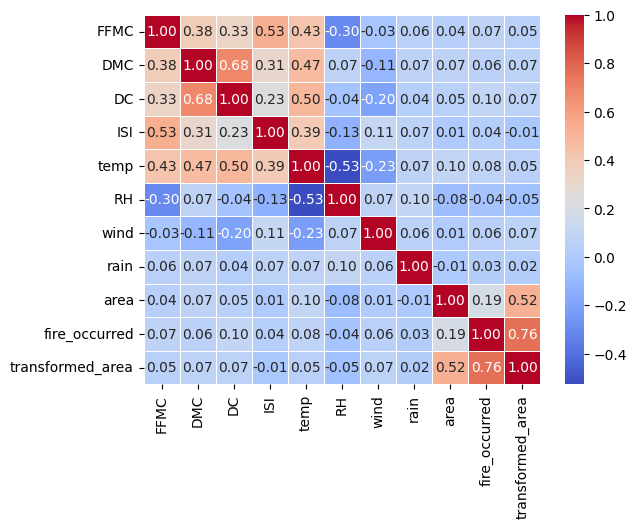

In [6]:
# Explore variable correlations
df_forest_fires_cont_vars = df_forest_fires.drop(columns = ['X', 'Y', 'month', 'day'])
cont_vars_corr_matrix = df_forest_fires_cont_vars.corr()
heatmap = sns.heatmap(cont_vars_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

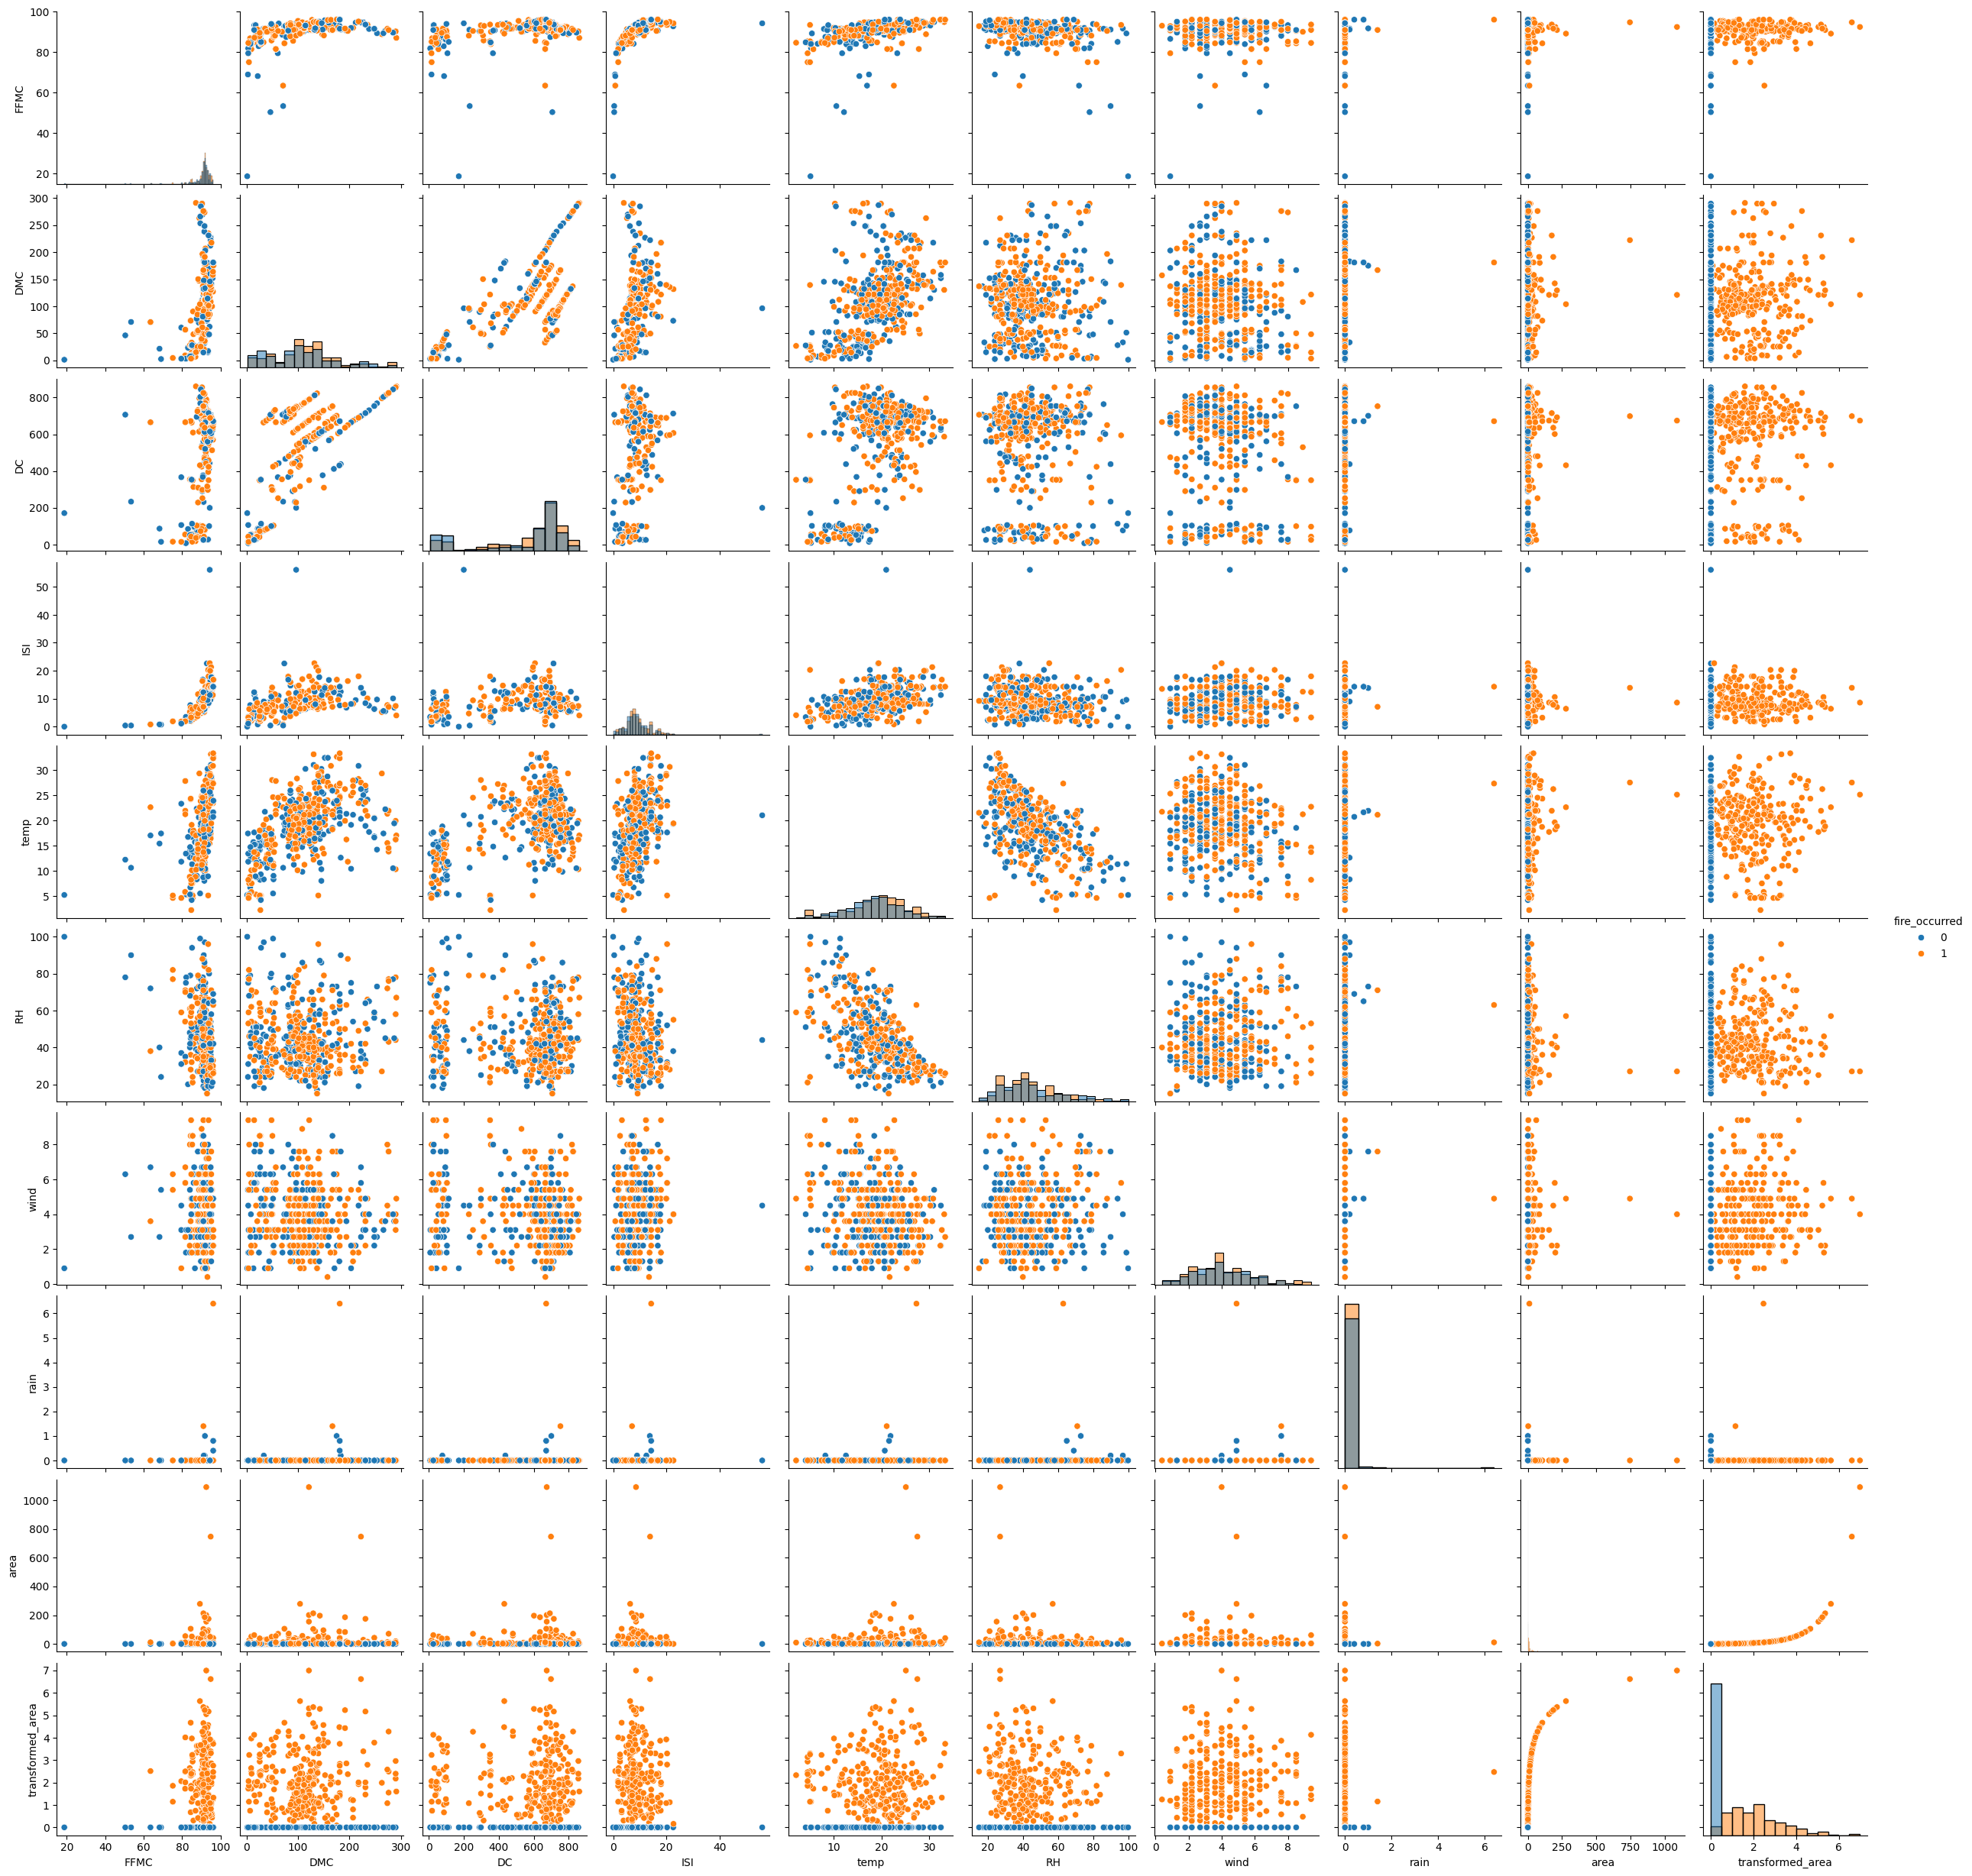

In [7]:
# Create pairplot based on fire occurrence
pairplot = sns.pairplot(df_forest_fires_cont_vars, hue='fire_occurred', diag_kind='hist')

Not sure how to better setup these pairplots or other plots to use to beneficially discover correlation

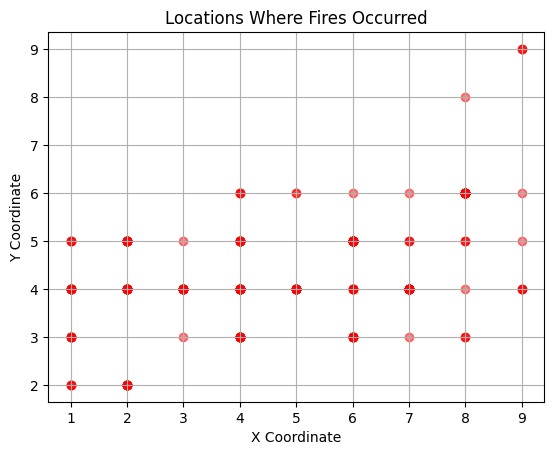

In [8]:
# Scatter plot of fire occurrences to visualize locations of fires 
df_fire_occurred = df_forest_fires[df_forest_fires['fire_occurred'] == 1]
plt.scatter(df_fire_occurred['X'], df_fire_occurred['Y'], color = 'red', alpha = 0.5)
plt.title('Locations Where Fires Occurred')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.grid(True)
plt.show()

Did a plot of the entries when fires occurred with the X Y data to get an idea of vunerable areas.

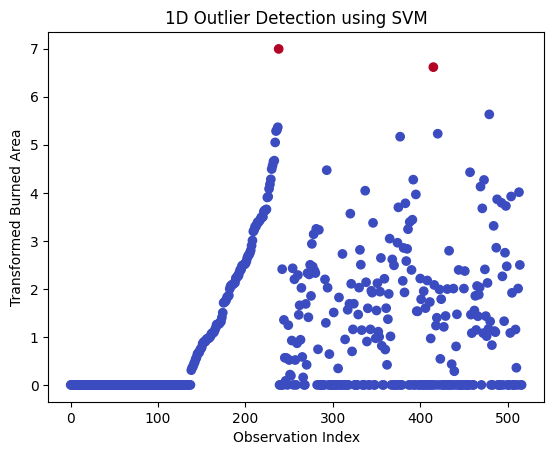

In [9]:
# Train OneClassSVM to detect outliers
data = df_forest_fires['transformed_area'].values.reshape(-1, 1)
svm_model = OneClassSVM(nu=0.01, gamma=0.02)  # Adjust 'nu' parameter based on your dataset
svm_model.fit(data)

# Predict inliers and outliers
predictions = svm_model.predict(data)

# Plot the results with index on the y-axis
plt.scatter(range(len(data)), data.flatten(), c=predictions, cmap='coolwarm_r')
plt.xlabel('Observation Index')
plt.ylabel('Transformed Burned Area')
plt.title('1D Outlier Detection using SVM')
plt.show()

The code above classifies the outliers with a one class svm on the "transformed_area" feature.

In [10]:
# Filter out observations with predictions of -1
df_forest_fires_filtered = df_forest_fires[predictions == 1]
df_forest_fires_filtered.reset_index(drop=True, inplace=True)
print(df_forest_fires.shape)
print(df_forest_fires_filtered.shape)

(517, 15)
(515, 15)


Removes the outliers previously classified as such.

In [11]:
# Data preprocessing:

# One-hot encoding for categorical vars ('month', 'day')
categorical_features = ['month', 'day']
one_hot_encoder = OneHotEncoder()
transformer = ColumnTransformer([("one_hot", one_hot_encoder, categorical_features)], remainder='passthrough')

# Apply dataset transformations
X_transformed = transformer.fit_transform(df_forest_fires_filtered.drop(columns=['area', 'fire_occurred', 'transformed_area']))

# Update columns after one-hot encoding
named_features = transformer.named_transformers_['one_hot'].get_feature_names_out()
remaining_features = df_forest_fires.drop(columns=['area', 'fire_occurred', 'month', 'day', 'transformed_area']).columns
all_features = list(named_features) + list(remaining_features)

# New dataframe
X = pd.DataFrame(X_transformed, columns=all_features)

# Define the target variable
y = df_forest_fires_filtered[['area', 'transformed_area']]

# Split data (80/20) into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_test.shape)
print(X_train.shape)
print(y_test.shape)
print(y_train.shape)

(103, 29)
(412, 29)
(103, 2)
(412, 2)


In [12]:
print(X_train.head())
print(y_train.head())

     month_apr  month_aug  month_dec  month_feb  month_jan  month_jul  \
320        0.0        0.0        0.0        0.0        0.0        0.0   
329        0.0        0.0        0.0        0.0        0.0        0.0   
173        0.0        0.0        0.0        0.0        0.0        0.0   
272        0.0        0.0        1.0        0.0        0.0        0.0   
495        0.0        1.0        0.0        0.0        0.0        0.0   

     month_jun  month_mar  month_may  month_nov  ...    X    Y  FFMC    DMC  \
320        0.0        0.0        0.0        0.0  ...  1.0  4.0  92.8  119.0   
329        0.0        0.0        0.0        0.0  ...  3.0  3.0  92.2  102.3   
173        0.0        0.0        0.0        0.0  ...  4.0  4.0  90.9  126.5   
272        0.0        0.0        0.0        0.0  ...  4.0  6.0  84.4   27.2   
495        0.0        0.0        0.0        0.0  ...  3.0  4.0  96.1  181.1   

        DC   ISI  temp    RH  wind  rain  
320  783.5   7.5  16.8  28.0   4.0   0.0  


In [13]:
# Create an SVR regressor